In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict
import pandas as pd
from tqdm.notebook import tqdm
import random

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
analysis_dir = Path("analysis")
layer = 11

In [2]:
def load_analyzed_chunks(analysis_dir: Path) -> List[Dict]:
    """
    Load all analyzed chunks from the analysis directory.
    
    Args:
        analysis_dir: Path to the analysis directory
        
    Returns:
        List of dictionaries containing chunk data
    """
    all_chunks = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Load chunks_analyzed.json if it exists
            chunks_file = seed_dir / "chunks.json"
            if chunks_file.exists():
                with open(chunks_file, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Add problem_id and seed to each chunk
                for chunk in chunks_data:
                    chunk['problem_id'] = problem_id
                    chunk['seed'] = seed
                    chunk['relative_position'] = chunk['index'] / len(chunks_data)
                
                all_chunks.extend([chunk for chunk in chunks_data if chunk['category'] != 'Unknown'])
    
    return all_chunks

# Load all analyzed chunks
all_chunks = load_analyzed_chunks(analysis_dir)
print(f"Loaded {len(all_chunks)} chunks from {len(set(chunk['problem_id'] for chunk in all_chunks))} problems")

  0%|          | 0/62 [00:00<?, ?it/s]

Loaded 4211 chunks from 61 problems


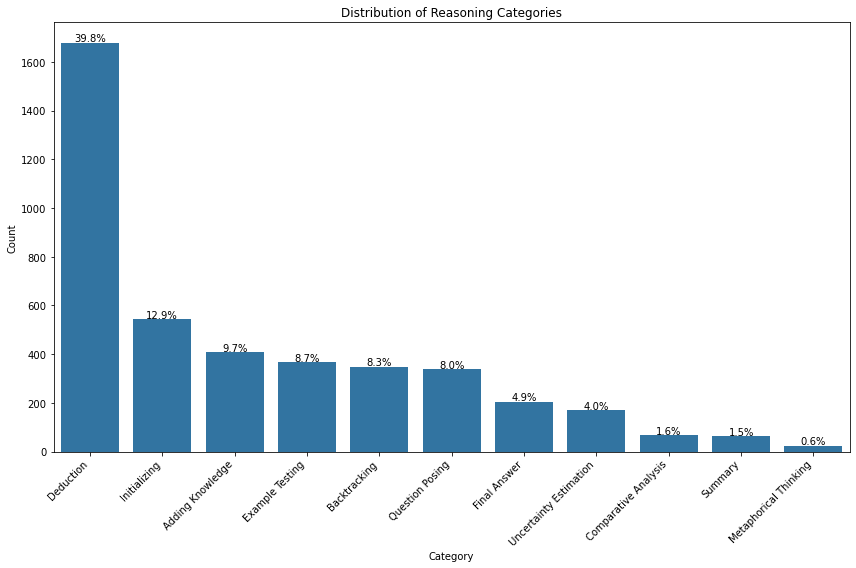

                  Category  Count  Percentage
0                Deduction   1678   39.848017
1             Initializing    543   12.894799
2         Adding Knowledge    408    9.688910
3          Example Testing    368    8.739017
4             Backtracking    348    8.264070
5          Question Posing    338    8.026597
6             Final Answer    205    4.868202
7   Uncertainty Estimation    169    4.013299
8     Comparative Analysis     67    1.591071
9                  Summary     63    1.496082
10   Metaphorical Thinking     24    0.569936


In [3]:
def plot_category_distribution(chunks: List[Dict]):
    """
    Plot the distribution of reasoning categories.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Count categories
    categories = [chunk['category'] for chunk in chunks]
    category_counts = Counter(categories)
    
    # Sort by frequency
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Create DataFrame for plotting
    df = pd.DataFrame(sorted_categories, columns=['Category', 'Count'])
    
    # Calculate percentage
    total = sum(df['Count'])
    df['Percentage'] = df['Count'] / total * 100
    
    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Category', y='Count', data=df)
    
    # Add percentage labels
    for i, row in enumerate(df.itertuples()):
        ax.text(i, row.Count + 5, f"{row.Percentage:.1f}%", ha='center')
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Reasoning Categories')
    plt.tight_layout()
    plt.show()
    
    return df

category_distribution = plot_category_distribution(all_chunks)
print(category_distribution)

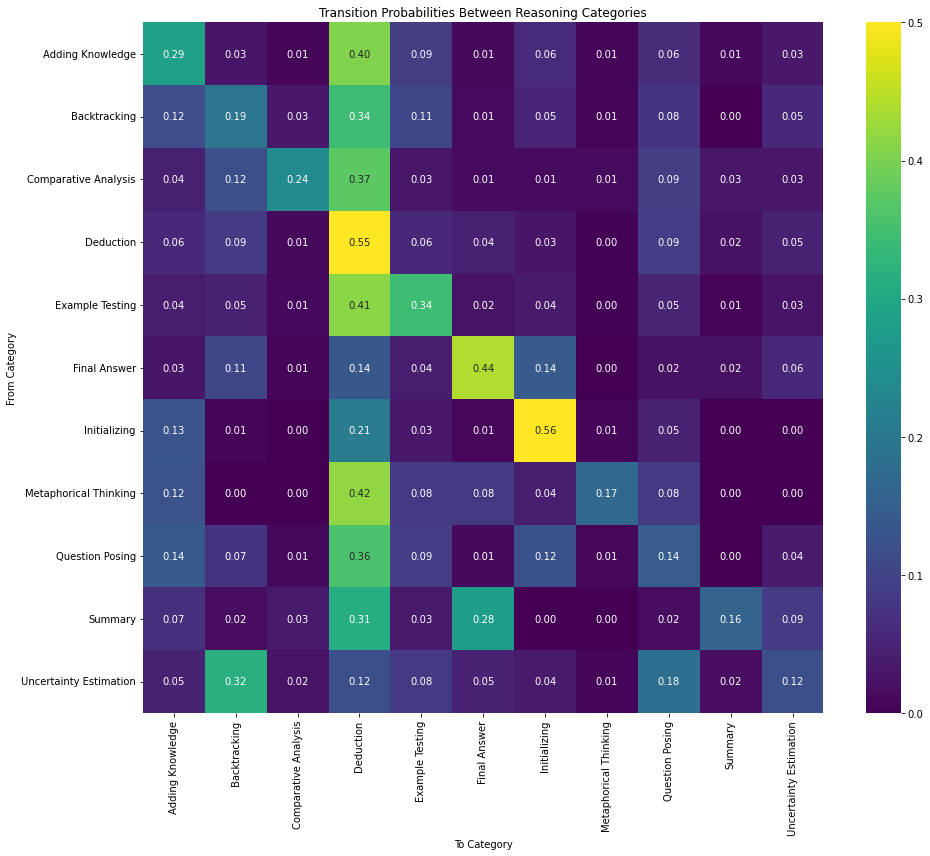

In [4]:
def compute_transition_matrix(chunks: List[Dict]):
    """
    Compute transition matrix between reasoning categories.
    
    Args:
        chunks: List of chunk dictionaries
        
    Returns:
        Transition matrix as DataFrame
    """
    # Get unique categories
    categories = sorted(set(chunk['category'] for chunk in chunks))
    
    # Initialize transition counts
    transitions = defaultdict(Counter)
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Count transitions within each problem
    for key, chunks in problem_chunks.items():
        # Sort chunks by index
        sorted_chunks = sorted(chunks, key=lambda x: x['index'])
        
        # Count transitions
        for i in range(len(sorted_chunks) - 1):
            from_cat = sorted_chunks[i]['category']
            to_cat = sorted_chunks[i + 1]['category']
            transitions[from_cat][to_cat] += 1
    
    # Create transition matrix
    matrix = []
    for from_cat in categories:
        row = []
        total = sum(transitions[from_cat].values())
        for to_cat in categories:
            # Calculate probability if total > 0
            prob = transitions[from_cat][to_cat] / total if total > 0 else 0
            row.append(prob)
        matrix.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(matrix, index=categories, columns=categories)
    
    return df

def plot_transition_matrix(transition_matrix: pd.DataFrame):
    """
    Plot transition matrix as heatmap.
    
    Args:
        transition_matrix: Transition matrix as DataFrame
    """
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        transition_matrix, 
        annot=True, 
        cmap='viridis', 
        vmin=0, 
        vmax=0.5,  # Cap at 0.5 for better color distribution
        fmt='.2f'
    )
    plt.title('Transition Probabilities Between Reasoning Categories')
    plt.xlabel('To Category')
    plt.ylabel('From Category')
    plt.tight_layout()
    plt.show()

# Compute and plot transition matrix
transition_matrix = compute_transition_matrix(all_chunks)
plot_transition_matrix(transition_matrix)

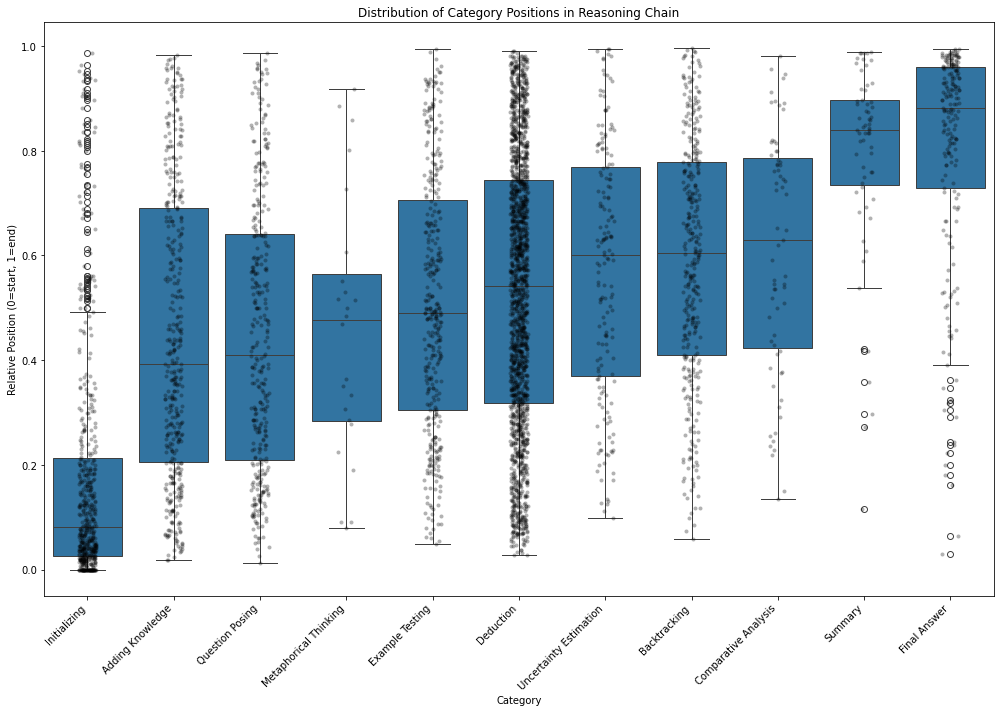

                  Category  Count  Mean Position   Std Dev       Min  \
0             Initializing    543       0.177282  0.229308  0.000000   
1         Adding Knowledge    408       0.445574  0.274969  0.018018   
2          Question Posing    338       0.445632  0.261104  0.012658   
8    Metaphorical Thinking     24       0.456704  0.246067  0.079646   
5          Example Testing    368       0.507929  0.244686  0.048193   
3                Deduction   1678       0.530992  0.259270  0.028571   
4   Uncertainty Estimation    169       0.572475  0.241036  0.097561   
9             Backtracking    348       0.590083  0.231252  0.058559   
6     Comparative Analysis     67       0.606860  0.229745  0.134831   
10                 Summary     63       0.788172  0.188061  0.115044   
7             Final Answer    205       0.800759  0.215855  0.029268   

         Max       25%       50%       75%  
0   0.986842  0.025978  0.081633  0.213203  
1   0.982759  0.205130  0.393398  0.690099  


In [5]:
def analyze_category_positions(chunks: List[Dict]):
    """
    Analyze the relative positions of each category in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
        
    Returns:
        DataFrame with position statistics for each category
    """
    # Group by category
    category_positions = defaultdict(list)
    
    for chunk in chunks:
        category = chunk['category']
        position = chunk['relative_position']
        category_positions[category].append(position)
    
    # Calculate statistics
    stats = []
    for category, positions in category_positions.items():
        stats.append({
            'Category': category,
            'Count': len(positions),
            'Mean Position': np.mean(positions),
            'Std Dev': np.std(positions),
            'Min': np.min(positions),
            'Max': np.max(positions),
            '25%': np.percentile(positions, 25),
            '50%': np.percentile(positions, 50),
            '75%': np.percentile(positions, 75)
        })
    
    # Create DataFrame
    df = pd.DataFrame(stats)
    df = df.sort_values('Mean Position')
    
    return df

def plot_category_positions(chunks: List[Dict]):
    """
    Plot the distribution of category positions in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Group by category
    category_positions = defaultdict(list)
    
    for chunk in chunks:
        category = chunk['category']
        position = chunk['relative_position']
        category_positions[category].append(position)
    
    # Create DataFrame for plotting
    data = []
    for category, positions in category_positions.items():
        for pos in positions:
            data.append({'Category': category, 'Relative Position': pos})
    
    df = pd.DataFrame(data)
    
    # Sort categories by mean position
    category_order = df.groupby('Category')['Relative Position'].mean().sort_values().index
    
    # Plot
    plt.figure(figsize=(14, 10))
    
    # Box plot
    ax = sns.boxplot(
        x='Category', 
        y='Relative Position', 
        data=df, 
        order=category_order
    )
    
    # Add scatter points for individual data points
    sns.stripplot(
        x='Category', 
        y='Relative Position', 
        data=df, 
        order=category_order,
        size=4, 
        color='black', 
        alpha=0.3
    )
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Category Positions in Reasoning Chain')
    plt.ylabel('Relative Position (0=start, 1=end)')
    plt.tight_layout()
    plt.show()
    
    # Return statistics
    return analyze_category_positions(chunks)

# Analyze and plot category positions
position_stats = plot_category_positions(all_chunks)
print(position_stats)

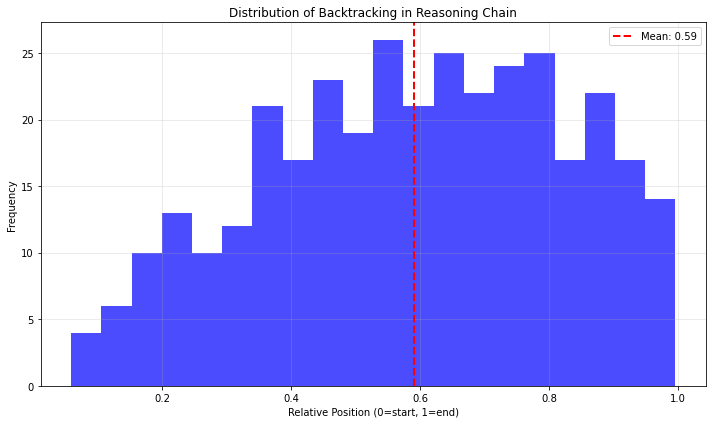

Backtracking Statistics:
  Count: 348
  Mean Position: 0.590
  Std Dev: 0.231
  Min: 0.059
  Max: 0.995


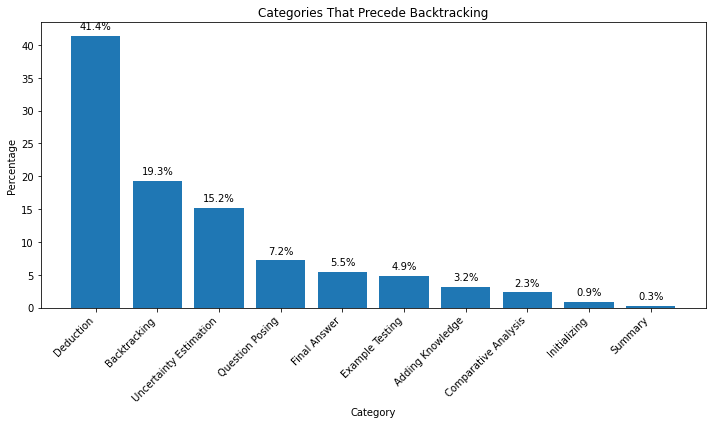

In [6]:
def analyze_backtracking(chunks: List[Dict]):
    """
    Analyze when backtracking occurs in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Filter for backtracking chunks
    backtracking_chunks = [chunk for chunk in chunks if chunk['category'] == 'Backtracking']
    
    if not backtracking_chunks:
        print("No backtracking chunks found in the dataset.")
        return
    
    # Get positions
    positions = [chunk['relative_position'] for chunk in backtracking_chunks]
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(positions, bins=20, alpha=0.7, color='blue')
    plt.axvline(np.mean(positions), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(positions):.2f}')
    
    plt.title('Distribution of Backtracking in Reasoning Chain')
    plt.xlabel('Relative Position (0=start, 1=end)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Backtracking Statistics:")
    print(f"  Count: {len(backtracking_chunks)}")
    print(f"  Mean Position: {np.mean(positions):.3f}")
    print(f"  Std Dev: {np.std(positions):.3f}")
    print(f"  Min: {np.min(positions):.3f}")
    print(f"  Max: {np.max(positions):.3f}")
    
    # What categories typically precede backtracking?
    preceding_categories = []
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Find categories that precede backtracking
    for key, prob_chunks in problem_chunks.items():
        # Sort chunks by index
        sorted_chunks = sorted(prob_chunks, key=lambda x: x['index'])
        
        # Find backtracking chunks
        for i, chunk in enumerate(sorted_chunks):
            if chunk['category'] == 'Backtracking' and i > 0:
                preceding_categories.append(sorted_chunks[i-1]['category'])
    
    # Count preceding categories
    preceding_counts = Counter(preceding_categories)
    
    # Plot
    plt.figure(figsize=(10, 6))
    categories, counts = zip(*preceding_counts.most_common())
    
    # Calculate percentages
    total = sum(counts)
    percentages = [count/total*100 for count in counts]
    
    # Create bars
    bars = plt.bar(categories, percentages)
    
    # Add percentage labels
    for bar, percentage in zip(bars, percentages):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            f"{percentage:.1f}%",
            ha='center'
        )
    
    plt.title('Categories That Precede Backtracking')
    plt.xlabel('Category')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze backtracking
analyze_backtracking(all_chunks)

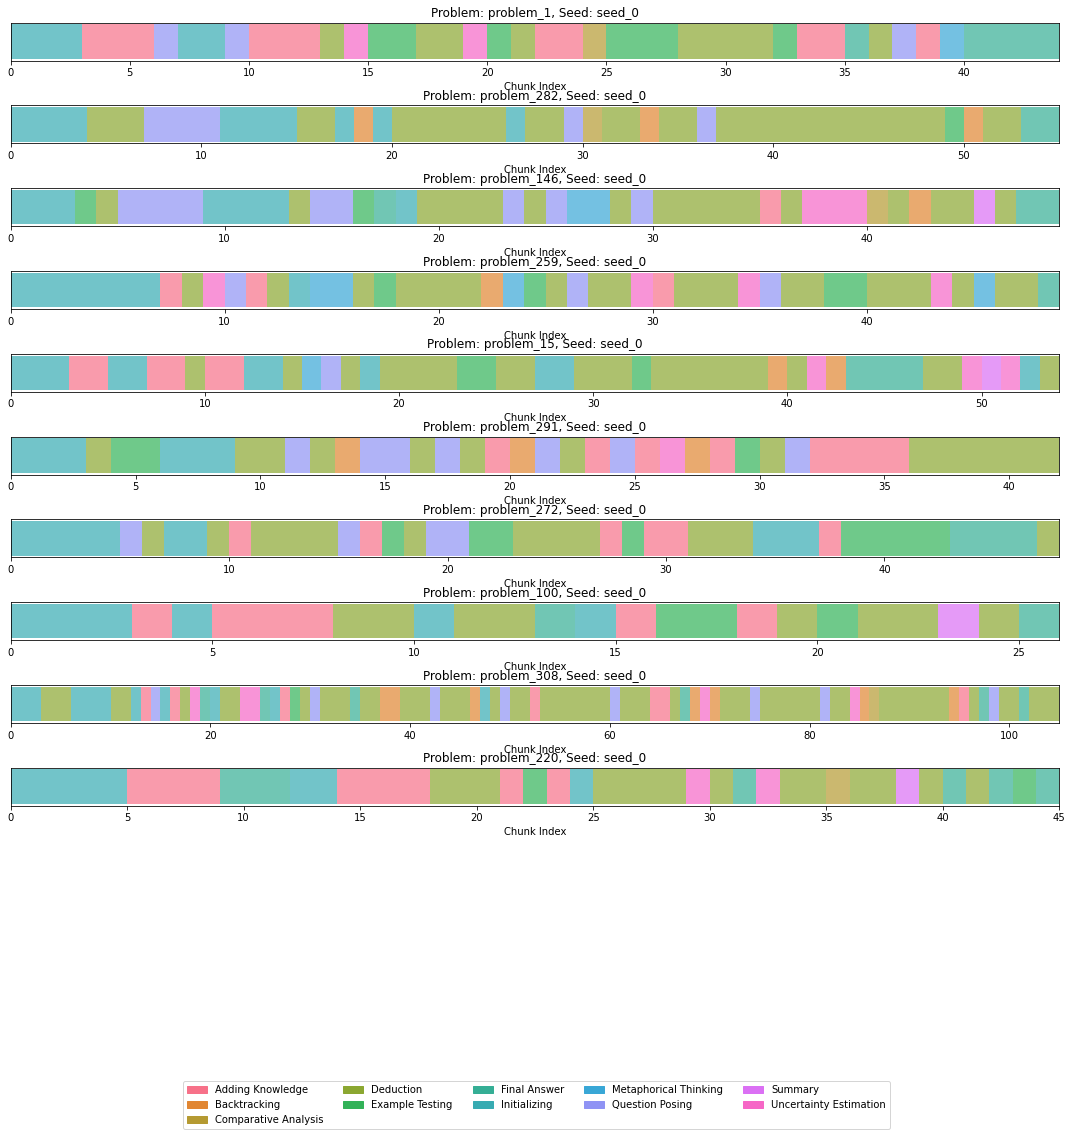

In [7]:
def visualize_category_sequences(chunks: List[Dict], max_problems: int = 10):
    """
    Visualize the sequence of categories for each problem.
    
    Args:
        chunks: List of chunk dictionaries
        max_problems: Maximum number of problems to visualize
    """
    # Get unique categories and assign colors
    categories = sorted(set(chunk['category'] for chunk in chunks))
    color_map = dict(zip(categories, sns.color_palette("husl", len(categories))))
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Select a subset of problems
    selected_problems = random.sample(list(problem_chunks.keys()), max_problems)
    
    # Create figure
    fig, axes = plt.subplots(len(selected_problems), 1, figsize=(15, len(selected_problems) * 1.5))
    if len(selected_problems) == 1:
        axes = [axes]
    
    # Plot each problem
    for i, (key, ax) in enumerate(zip(selected_problems, axes)):
        problem_id, seed = key
        prob_chunks = sorted(problem_chunks[key], key=lambda x: x['index'])
        
        # Create colored blocks for each category
        for j, chunk in enumerate(prob_chunks):
            category = chunk['category']
            ax.barh(0, 1, left=j, color=color_map[category], alpha=0.7)
            
        # Set labels
        ax.set_yticks([])
        ax.set_xlabel('Chunk Index')
        ax.set_title(f'Problem: {problem_id}, Seed: {seed}')
        ax.set_xlim(0, len(prob_chunks))
    
    # Create legend
    handles = [plt.Rectangle((0,0),1,1, color=color_map[cat]) for cat in categories]
    fig.legend(handles, categories, loc='upper center', bbox_to_anchor=(0.5, 0), 
               ncol=min(5, len(categories)), frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15 + 0.02 * min(5, len(categories)))
    plt.show()

# Visualize category sequences
visualize_category_sequences(all_chunks)

  0%|          | 0/62 [00:00<?, ?it/s]

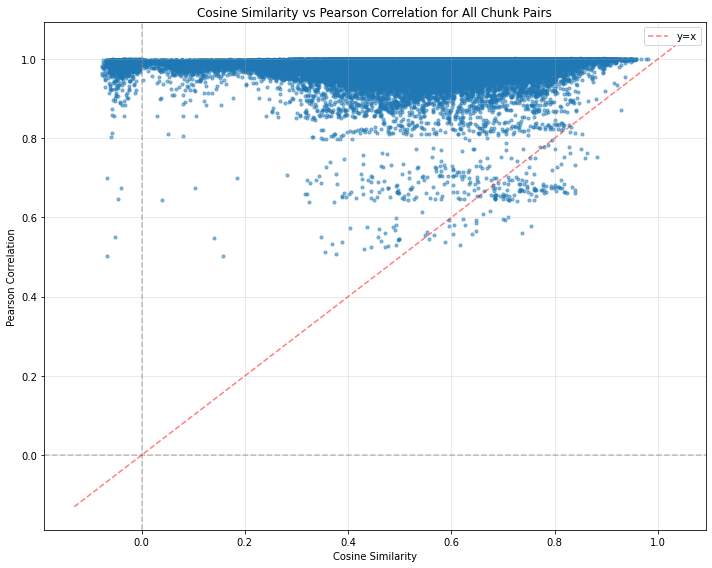

Correlation between cosine similarity and Pearson correlation: -0.061


In [26]:
def analyze_cosine_vs_correlation(analysis_dir: Path):
    """
    Analyze the relationship between cosine similarity and Pearson correlation.
    
    Args:
        analysis_dir: Path to the analysis directory
    """
    # Store data for all problems
    all_data = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Check if both matrices exist
            cosine_path = seed_dir / f"chunk_cosine_similarity_layer_{layer}.npy"
            corr_path = seed_dir / f"chunk_correlation_layer_{layer}.npy"
            chunks_path = seed_dir / "chunks.json"
            
            if cosine_path.exists() and corr_path.exists() and chunks_path.exists():
                # Load matrices
                cosine_matrix = np.load(cosine_path)
                corr_matrix = np.load(corr_path)
                
                # Load chunk data
                with open(chunks_path, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Extract chunk categories
                categories = [chunk['category'] for chunk in chunks_data]
                abbreviations = [chunk['abbreviation'] for chunk in chunks_data]
                
                # Ensure matrices have the same shape
                if cosine_matrix.shape == corr_matrix.shape:
                    n = cosine_matrix.shape[0]
                    
                    # Extract all pairs (excluding self-comparisons)
                    for i in range(n):
                        for j in range(i+1, n):  # Only upper triangle
                            if categories[i] != 'Unknown' and categories[j] != 'Unknown':
                                all_data.append({
                                    'problem_id': problem_id,
                                    'seed': seed,
                                    'chunk_i': i,
                                    'chunk_j': j,
                                    'category_i': categories[i],
                                    'category_j': categories[j],
                                    'abbrev_i': abbreviations[i],
                                    'abbrev_j': abbreviations[j],
                                    'cosine_sim': cosine_matrix[i, j],
                                    'correlation': corr_matrix[i, j]
                                })
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    return df

# Load and analyze cosine vs correlation data
cosine_corr_df = analyze_cosine_vs_correlation(analysis_dir)

# Plot the relationship
plt.figure(figsize=(10, 8))
plt.scatter(
    cosine_corr_df['cosine_sim'], 
    cosine_corr_df['correlation'],
    alpha=0.5,
    s=10
)

plt.xlabel('Cosine Similarity')
plt.ylabel('Pearson Correlation')
plt.title('Cosine Similarity vs Pearson Correlation for All Chunk Pairs')

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add a diagonal line for reference
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red', linestyle='--', alpha=0.5, label='y=x')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation between cosine similarity and Pearson correlation
corr = cosine_corr_df['cosine_sim'].corr(cosine_corr_df['correlation'])
print(f"Correlation between cosine similarity and Pearson correlation: {corr:.3f}")

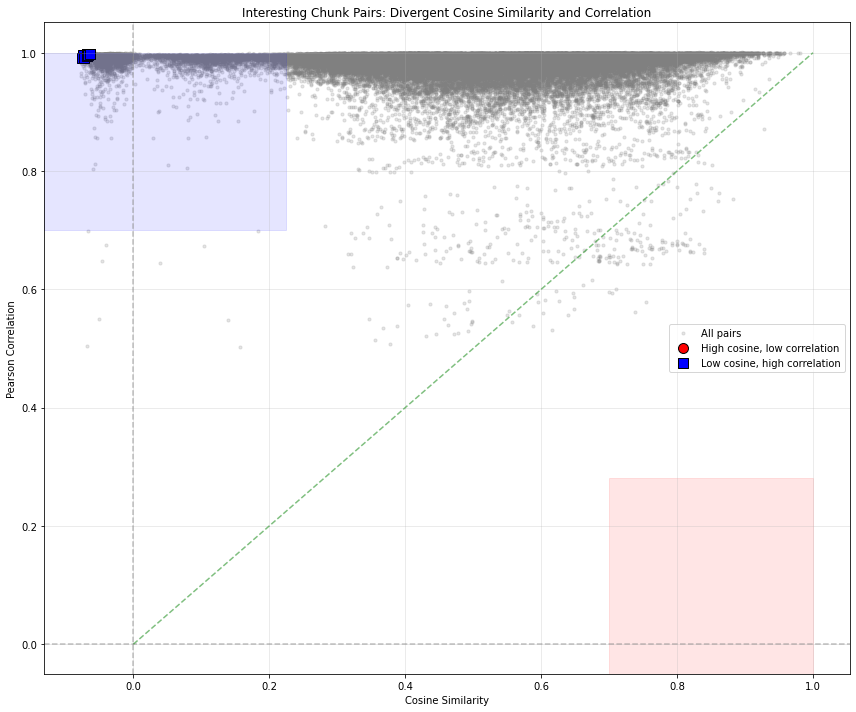

High Cosine Similarity, Low Correlation Pairs:
Empty DataFrame
Columns: [problem_id, category_i, category_j, cosine_sim, correlation]
Index: []

Low Cosine Similarity, High Correlation Pairs:
        problem_id    category_i        category_j  cosine_sim  correlation
47737  problem_146  Initializing   Question Posing   -0.074054     0.996337
89357  problem_182  Initializing      Initializing   -0.068852     0.997314
48928   problem_15  Initializing         Deduction   -0.068604     0.997314
92756  problem_185  Initializing  Adding Knowledge   -0.075089     0.990476
51965  problem_159  Initializing      Backtracking   -0.068196     0.997314
48919   problem_15  Initializing         Deduction   -0.072313     0.990476
995     problem_10  Initializing      Backtracking   -0.064327     0.998291
92766  problem_185  Initializing   Question Posing   -0.067999     0.994383
75663  problem_167  Initializing      Initializing   -0.066632     0.995360
54774  problem_165  Initializing         Deducti

In [27]:
def find_interesting_chunk_pairs(df: pd.DataFrame, n_pairs: int = 10):
    """
    Find interesting chunk pairs with:
    1. High cosine similarity but low correlation
    2. Low cosine similarity but high correlation
    
    Args:
        df: DataFrame with cosine similarity and correlation data
        n_pairs: Number of pairs to find in each category
        
    Returns:
        DataFrames with interesting pairs
    """
    # Calculate the difference between cosine similarity and correlation
    df['cos_minus_corr'] = df['cosine_sim'] - df['correlation']
    df['corr_minus_cos'] = df['correlation'] - df['cosine_sim']
    
    # Find pairs with high cosine but low correlation
    high_cos_low_corr = df[
        (df['cosine_sim'] > 0.7) &  # High cosine threshold
        (df['correlation'] < 0.3)    # Low correlation threshold
    ].sort_values('cos_minus_corr', ascending=False).head(n_pairs)
    
    # Find pairs with low cosine but high correlation
    low_cos_high_corr = df[
        (df['cosine_sim'] < 0.3) &   # Low cosine threshold
        (df['correlation'] > 0.7)     # High correlation threshold
    ].sort_values('corr_minus_cos', ascending=False).head(n_pairs)
    
    return high_cos_low_corr, low_cos_high_corr

def plot_interesting_pairs(df: pd.DataFrame):
    """
    Create a scatter plot highlighting interesting pairs.
    
    Args:
        df: DataFrame with cosine similarity and correlation data
    """
    # Find interesting pairs
    high_cos_low_corr, low_cos_high_corr = find_interesting_chunk_pairs(df)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    plt.scatter(
        df['cosine_sim'], 
        df['correlation'],
        alpha=0.2,
        s=10,
        color='gray',
        label='All pairs'
    )
    
    # Highlight high cosine, low correlation pairs
    plt.scatter(
        high_cos_low_corr['cosine_sim'],
        high_cos_low_corr['correlation'],
        alpha=1.0,
        s=100,
        color='red',
        marker='o',
        edgecolor='black',
        label='High cosine, low correlation'
    )
    
    # Highlight low cosine, high correlation pairs
    plt.scatter(
        low_cos_high_corr['cosine_sim'],
        low_cos_high_corr['correlation'],
        alpha=1.0,
        s=100,
        color='blue',
        marker='s',
        edgecolor='black',
        label='Low cosine, high correlation'
    )
    
    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', alpha=0.5)
    
    # Add regions
    plt.axhspan(0.7, 1.0, xmax=0.3, alpha=0.1, color='blue', label='_nolegend_')
    plt.axvspan(0.7, 1.0, ymax=0.3, alpha=0.1, color='red', label='_nolegend_')
    
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Pearson Correlation')
    plt.title('Interesting Chunk Pairs: Divergent Cosine Similarity and Correlation')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return high_cos_low_corr, low_cos_high_corr

# Plot interesting pairs
high_cos_low_corr, low_cos_high_corr = plot_interesting_pairs(cosine_corr_df)

# Print details about interesting pairs
print("High Cosine Similarity, Low Correlation Pairs:")
print(high_cos_low_corr[['problem_id', 'category_i', 'category_j', 'cosine_sim', 'correlation']])
print("\nLow Cosine Similarity, High Correlation Pairs:")
print(low_cos_high_corr[['problem_id', 'category_i', 'category_j', 'cosine_sim', 'correlation']])

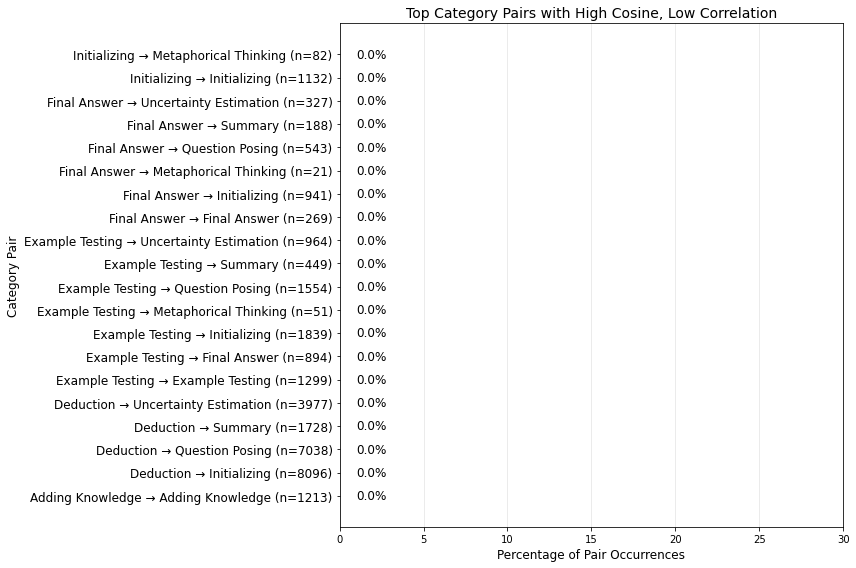

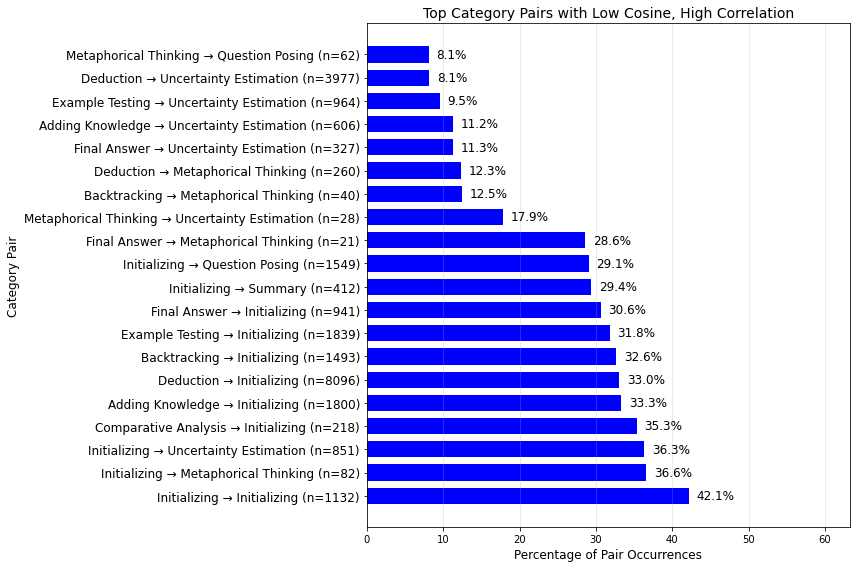

In [29]:
def analyze_category_pairs(df: pd.DataFrame):
    """
    Analyze which category pairs tend to have high cosine but low correlation
    and which have low cosine but high correlation.
    
    Args:
        df: DataFrame with cosine similarity and correlation data
    """
    # Create category pair labels
    df['category_pair'] = df.apply(
        lambda row: f"{row['category_i']} → {row['category_j']}" 
        if row['category_i'] <= row['category_j'] 
        else f"{row['category_j']} → {row['category_i']}", 
        axis=1
    )
    
    # Define interesting pairs
    df['high_cos_low_corr'] = (df['cosine_sim'] > 0.7) & (df['correlation'] < 0.3)
    df['low_cos_high_corr'] = (df['cosine_sim'] < 0.3) & (df['correlation'] > 0.7)
    
    # Calculate percentages by category pair
    # First, get total counts for each category pair
    total_by_pair = df.groupby('category_pair').size()
    
    # Get counts of interesting pairs by category
    high_cos_low_corr_counts = df[df['high_cos_low_corr']].groupby('category_pair').size()
    low_cos_high_corr_counts = df[df['low_cos_high_corr']].groupby('category_pair').size()
    
    # Calculate percentages (only for pairs with at least 5 total occurrences)
    high_cos_low_corr_pct = pd.Series(index=total_by_pair.index, dtype=float)
    low_cos_high_corr_pct = pd.Series(index=total_by_pair.index, dtype=float)
    
    for pair in total_by_pair.index:
        if total_by_pair[pair] >= 5:  # Minimum threshold to avoid small sample size issues
            high_cos_low_corr_pct[pair] = high_cos_low_corr_counts.get(pair, 0) / total_by_pair[pair] * 100
            low_cos_high_corr_pct[pair] = low_cos_high_corr_counts.get(pair, 0) / total_by_pair[pair] * 100
    
    # Get top pairs by percentage
    top_high_cos_low_corr = high_cos_low_corr_pct.dropna().sort_values(ascending=False).head(20)
    top_low_cos_high_corr = low_cos_high_corr_pct.dropna().sort_values(ascending=False).head(20)
    
    # Create separate figures for each plot to avoid layout issues
    # Figure 1: High cosine, low correlation
    if not top_high_cos_low_corr.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_high_cos_low_corr.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_high_cos_low_corr.values, color='red', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_high_cos_low_corr.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with High Cosine, Low Correlation', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_high_cos_low_corr.iloc[0] if not top_high_cos_low_corr.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with high cosine, low correlation", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Figure 2: Low cosine, high correlation
    if not top_low_cos_high_corr.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_low_cos_high_corr.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_low_cos_high_corr.values, color='blue', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_low_cos_high_corr.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with Low Cosine, High Correlation', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_low_cos_high_corr.iloc[0] if not top_low_cos_high_corr.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with low cosine, high correlation", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Return both percentages and counts for reference
    high_cos_result = pd.DataFrame({'Percentage': top_high_cos_low_corr})
    
    if not top_high_cos_low_corr.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_high_cos_low_corr.index:
            counts.append(high_cos_low_corr_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        high_cos_result['Count'] = counts
        high_cos_result['Total'] = totals
    
    low_cos_result = pd.DataFrame({'Percentage': top_low_cos_high_corr})
    
    if not top_low_cos_high_corr.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_low_cos_high_corr.index:
            counts.append(low_cos_high_corr_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        low_cos_result['Count'] = counts
        low_cos_result['Total'] = totals
    
    return high_cos_result, low_cos_result

# Analyze category pairs
top_high_cos_low_corr, top_low_cos_high_corr = analyze_category_pairs(cosine_corr_df)

In [33]:
def load_chunk_text(problem_id, seed, chunk_idx, analysis_dir):
    """Load the text of a specific chunk."""
    chunks_file = analysis_dir / problem_id / seed / "chunks.json"
    if chunks_file.exists():
        with open(chunks_file, 'r', encoding='utf-8') as f:
            chunks_data = json.load(f)
            for chunk in chunks_data:
                if chunk['index'] == chunk_idx:
                    return chunk['text']
    return "Chunk text not found"

def display_example_pairs(high_cos_low_corr, low_cos_high_corr, analysis_dir, num_examples=10):
    """
    Display random examples of chunk pairs with interesting properties.
    
    Args:
        high_cos_low_corr: DataFrame with high cosine, low correlation pairs
        low_cos_high_corr: DataFrame with low cosine, high correlation pairs
        analysis_dir: Path to the analysis directory
        num_examples: Number of random examples to display
    """
    # Combine both types of examples
    all_examples = []
    
    if not high_cos_low_corr.empty:
        high_cos_samples = high_cos_low_corr.sample(min(num_examples // 2, len(high_cos_low_corr)))
        for _, row in high_cos_samples.iterrows():
            all_examples.append({
                'type': 'High Cosine, Low Correlation',
                'cosine_sim': row['cosine_sim'],
                'correlation': row['correlation'],
                'problem_id': row['problem_id'],
                'seed': row['seed'],
                'chunk_i': row['chunk_i'],
                'chunk_j': row['chunk_j'],
                'category_i': row['category_i'],
                'category_j': row['category_j']
            })
    
    if not low_cos_high_corr.empty:
        low_cos_samples = low_cos_high_corr.sample(min(num_examples // 2, len(low_cos_high_corr)))
        for _, row in low_cos_samples.iterrows():
            all_examples.append({
                'type': 'Low Cosine, High Correlation',
                'cosine_sim': row['cosine_sim'],
                'correlation': row['correlation'],
                'problem_id': row['problem_id'],
                'seed': row['seed'],
                'chunk_i': row['chunk_i'],
                'chunk_j': row['chunk_j'],
                'category_i': row['category_i'],
                'category_j': row['category_j']
            })
    
    # If we don't have enough examples, fill with more from whichever category has data
    remaining = num_examples - len(all_examples)
    if remaining > 0:
        if not high_cos_low_corr.empty and len(high_cos_low_corr) > len(high_cos_samples):
            additional = high_cos_low_corr.drop(high_cos_samples.index).sample(min(remaining, len(high_cos_low_corr) - len(high_cos_samples)))
            for _, row in additional.iterrows():
                all_examples.append({
                    'type': 'High Cosine, Low Correlation',
                    'cosine_sim': row['cosine_sim'],
                    'correlation': row['correlation'],
                    'problem_id': row['problem_id'],
                    'seed': row['seed'],
                    'chunk_i': row['chunk_i'],
                    'chunk_j': row['chunk_j'],
                    'category_i': row['category_i'],
                    'category_j': row['category_j']
                })
        elif not low_cos_high_corr.empty and len(low_cos_high_corr) > len(low_cos_samples):
            additional = low_cos_high_corr.drop(low_cos_samples.index).sample(min(remaining, len(low_cos_high_corr) - len(low_cos_samples)))
            for _, row in additional.iterrows():
                all_examples.append({
                    'type': 'Low Cosine, High Correlation',
                    'cosine_sim': row['cosine_sim'],
                    'correlation': row['correlation'],
                    'problem_id': row['problem_id'],
                    'seed': row['seed'],
                    'chunk_i': row['chunk_i'],
                    'chunk_j': row['chunk_j'],
                    'category_i': row['category_i'],
                    'category_j': row['category_j']
                })
    
    # Shuffle examples
    random.shuffle(all_examples)
    
    # Display examples
    for i, example in enumerate(all_examples[:num_examples], 1):
        print(f"\n--- Example {i}: {example['type']} ---")
        print(f"Cosine Similarity: {example['cosine_sim']:.3f}, Correlation: {example['correlation']:.3f}")
        print(f"Problem: {example['problem_id']}, Seed: {example['seed']}")
        print(f"Categories: {example['category_i']} → {example['category_j']}")
        
        text_i = load_chunk_text(example['problem_id'], example['seed'], example['chunk_i'], analysis_dir)
        text_j = load_chunk_text(example['problem_id'], example['seed'], example['chunk_j'], analysis_dir)
        
        print("\nChunk 1:")
        print(text_i[:300] + ("..." if len(text_i) > 300 else ""))
        
        print("\nChunk 2:")
        print(text_j[:300] + ("..." if len(text_j) > 300 else ""))
        print("-" * 80)

# Display 10 random examples
display_example_pairs(high_cos_low_corr, low_cos_high_corr, analysis_dir, num_examples=10)


--- Example 1: Low Cosine, High Correlation ---
Cosine Similarity: -0.068, Correlation: 0.994
Problem: problem_185, Seed: seed_0
Categories: Initializing → Question Posing

Chunk 1:
Solve this problem step by step.

Chunk 2:
So, what could cause an increase in insects to be countered?

One possibility is predators.
--------------------------------------------------------------------------------

--- Example 2: Low Cosine, High Correlation ---
Cosine Similarity: -0.064, Correlation: 0.998
Problem: problem_10, Seed: seed_0
Categories: Initializing → Backtracking

Chunk 1:
Solve this problem step by step.

Chunk 2:
I'm going in circles here.
--------------------------------------------------------------------------------

--- Example 3: Low Cosine, High Correlation ---
Cosine Similarity: -0.069, Correlation: 0.997
Problem: problem_15, Seed: seed_0
Categories: Initializing → Deduction

Chunk 1:
Solve this problem step by step.

Chunk 2:
0.35 * 1.75.
---------------------------------------

  0%|          | 0/62 [00:00<?, ?it/s]

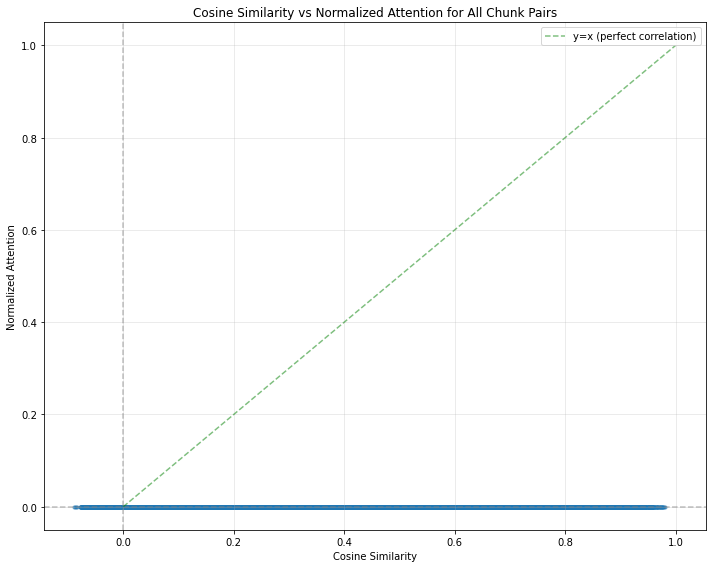

Correlation between cosine similarity and normalized attention: nan


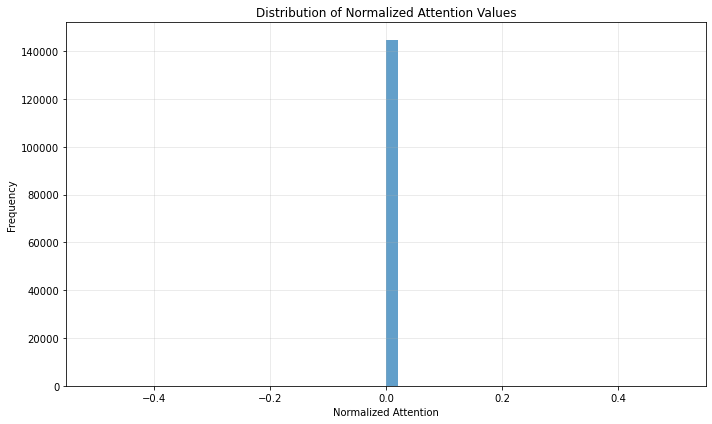

         problem_id    seed  chunk_i  chunk_j    category_i        category_j  \
0         problem_1  seed_0        0        1  Initializing      Initializing   
1         problem_1  seed_0        0        2  Initializing      Initializing   
2         problem_1  seed_0        0        3  Initializing  Adding Knowledge   
3         problem_1  seed_0        0        4  Initializing  Adding Knowledge   
4         problem_1  seed_0        0        5  Initializing  Adding Knowledge   
...             ...     ...      ...      ...           ...               ...   
144786  problem_253  seed_0       50       52     Deduction         Deduction   
144787  problem_253  seed_0       50       53     Deduction         Deduction   
144788  problem_253  seed_0       51       52     Deduction         Deduction   
144789  problem_253  seed_0       51       53     Deduction         Deduction   
144790  problem_253  seed_0       52       53     Deduction         Deduction   

        cosine_sim  attenti

In [ ]:
def analyze_attention_vs_cosine(analysis_dir: Path):
    """
    Analyze the relationship between attention and cosine similarity.
    
    Args:
        analysis_dir: Path to the analysis directory
    """
    # Store data for all problems
    all_data = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Check if both matrices exist
            cosine_path = seed_dir / f"chunk_cosine_similarity_layer_{layer}.npy"
            attention_path = seed_dir / f"chunk_attention_layer_{layer}.npy"
            chunks_path = seed_dir / "chunks.json"
            
            if cosine_path.exists() and attention_path.exists() and chunks_path.exists():
                # Load matrices
                cosine_matrix = np.load(cosine_path)
                attention_matrix = np.load(attention_path)
                
                print(attention_matrix)
                
                # Normalize attention matrix to [0, 1] range for each row
                # This ensures attention weights sum to 1 for each source chunk
                normalized_attention = np.zeros_like(attention_matrix)
                for i in range(len(attention_matrix)):
                    row_sum = attention_matrix[i].sum()
                    if row_sum > 0:
                        normalized_attention[i] = attention_matrix[i] / row_sum
                
                # Load chunks data to get categories
                with open(chunks_path, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Extract categories
                categories = [chunk.get('category', 'Unknown') for chunk in chunks_data]
                
                # Get matrix dimensions
                n = len(cosine_matrix)
                
                # Collect data for each pair of chunks
                for i in range(n):
                    for j in range(i+1, n):  # Only upper triangle to avoid duplicates
                        all_data.append({
                            'problem_id': problem_id,
                            'seed': seed,
                            'chunk_i': i,
                            'chunk_j': j,
                            'category_i': categories[i],
                            'category_j': categories[j],
                            'cosine_sim': cosine_matrix[i, j],
                            'attention': normalized_attention[i, j],
                            'raw_attention': attention_matrix[i, j]
                        })
    
    # Convert to DataFrame
    attention_cosine_df = pd.DataFrame(all_data)
    
    # Plot scatter
    plt.figure(figsize=(10, 8))
    plt.scatter(
        attention_cosine_df['cosine_sim'], 
        attention_cosine_df['attention'],
        alpha=0.5,
        s=10
    )

    plt.xlabel('Cosine Similarity')
    plt.ylabel('Normalized Attention')
    plt.title('Cosine Similarity vs Normalized Attention for All Chunk Pairs')

    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', alpha=0.5, label='y=x (perfect correlation)')

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate correlation between cosine similarity and attention
    corr = attention_cosine_df['cosine_sim'].corr(attention_cosine_df['attention'])
    print(f"Correlation between cosine similarity and normalized attention: {corr:.3f}")
    
    # Also show distribution of attention values
    plt.figure(figsize=(10, 6))
    plt.hist(attention_cosine_df['attention'], bins=50, alpha=0.7)
    plt.title('Distribution of Normalized Attention Values')
    plt.xlabel('Normalized Attention')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return attention_cosine_df

# Analyze attention vs cosine similarity
attention_cosine_df = analyze_attention_vs_cosine(analysis_dir)
print(attention_cosine_df)